<a href="https://colab.research.google.com/github/Andyqballer/Home-Work-7/blob/main/Homework7Problem2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Files already downloaded and verified
Files already downloaded and verified
Model Size: 12,650,058 parameters
Starting training...
Epoch [10/200]
Training Loss: 0.0842
Test Accuracy: 81.74%
Epoch [20/200]
Training Loss: 0.0375
Test Accuracy: 83.10%
Epoch [30/200]
Training Loss: 0.0171
Test Accuracy: 84.64%
Epoch [40/200]
Training Loss: 0.0101
Test Accuracy: 83.69%
Epoch [50/200]
Training Loss: 0.0114
Test Accuracy: 85.73%
Epoch [60/200]
Training Loss: 0.0124
Test Accuracy: 85.52%
Epoch [70/200]
Training Loss: 0.0046
Test Accuracy: 85.07%
Epoch [80/200]
Training Loss: 0.0098
Test Accuracy: 85.26%
Epoch [90/200]
Training Loss: 0.0137
Test Accuracy: 84.92%
Epoch [100/200]
Training Loss: 0.0064
Test Accuracy: 84.93%
Epoch [110/200]
Training Loss: 0.0046
Test Accuracy: 84.16%
Epoch [120/200]
Training Loss: 0.0001
Test Accuracy: 86.53%
Epoch [130/200]
Training Loss: 0.0000
Test Accuracy: 86.78%
Epoch [140/200]
Training Loss: 0.0001
Test Accuracy: 86.87%
Epoch [150/200]
Training Loss: 0.0000


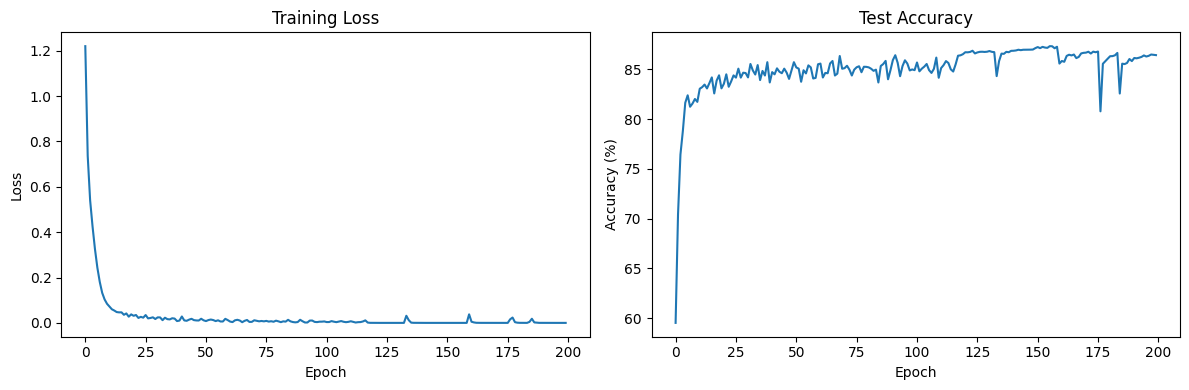

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 200
batch_size = 128
learning_rate = 0.001

# CIFAR-10 dataset with normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)

# Basic Block with skip connection
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Skip connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels,
                         kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(identity)
        out = self.relu(out)

        return out

# ResNet-10
class ResNet10(nn.Module):
    def __init__(self, block=BasicBlock, num_classes=10):
        super(ResNet10, self).__init__()

        # Initial convolution layer
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # ResNet blocks
        self.layer1 = self.make_layer(block, 64, 2)  # 2 blocks
        self.layer2 = self.make_layer(block, 128, 3, stride=2)  # 3 blocks
        self.layer3 = self.make_layer(block, 256, 3, stride=2)  # 3 blocks
        self.layer4 = self.make_layer(block, 512, 2, stride=2)  # 2 blocks

        # Global average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def make_layer(self, block, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

# Training and evaluation functions
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(train_loader)

def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

# Initialize model and training components
model = ResNet10().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Print model size
model_size = count_parameters(model)
print(f'Model Size: {model_size:,} parameters')

# Training loop
print("Starting training...")
start_time = time.time()
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    test_accuracy = evaluate(model, test_loader)

    train_losses.append(train_loss)
    test_accuracies.append(test_accuracy)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Training Loss: {train_loss:.4f}')
        print(f'Test Accuracy: {test_accuracy:.2f}%')

training_time = time.time() - start_time

# Final results
print("\nTraining completed!")
print(f'Total training time: {training_time:.2f} seconds')
print(f'Final training loss: {train_losses[-1]:.4f}')
print(f'Final test accuracy: {test_accuracies[-1]:.2f}%')
print(f'Model size: {model_size:,} parameters')

# Plot training progress
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()